In [2]:
# preamble
import glob
import os
from PIL import Image
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from models import UNet, MVCNN
from dataloader import SimulationData
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision
from utils import train, train_anno, predict, score_fluoroscopy, score_time, score_xray, score_retries_cannulated_dhs, score_retries_hansson, \
                drill_dist_hansson, guidewire_dist, drill_dist_hansson
from skimage.io import imread_collection
import matplotlib.pyplot as plt
import pandas as pd
import os
from unittest import TestLoader
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm
plt.style.use('seaborn')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
# set up weights and biases (wandb.ai)

import wandb

wandb.init(project = "ort-project", entity = "ditteblom", reinit=True)

wandb: Currently logged in as: macaroni (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Create the dataset as a torch dataset.

In [3]:
# initialize scaler
repair_type = "001_hansson_pin_system"
#size = 129 # for baseline
#size = 225 # for VGG16
#size = 300 # for inception v3
size = 224
train_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize((size,size)),
                                    #transforms.Grayscale(num_output_channels = 1),
                                    #transforms.RandomChoice([transforms.GaussianBlur(kernel_size=3, sigma=(1, 1)),
                                    transforms.RandomRotation(degrees=(15)),
                                    ])
test_transform = val_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize((size,size)),
                                    #transforms.Grayscale(num_output_channels = 1),
                                    ])

train_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize((size,size)),])

batch_size = 12

# divide data into train-, validation- and testset
trainset = SimulationData(repair_type = repair_type, split = "train", transform=train_transform, annotation = False)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers = 4)

valset = SimulationData(repair_type = repair_type, split = "val", transform=val_transform, annotation = False)
val_loader = DataLoader(valset, batch_size = batch_size, shuffle = True, num_workers = 4)

testset = SimulationData(repair_type=repair_type, split = "test", transform=test_transform, annotation = False)
test_loader = DataLoader(testset, batch_size= batch_size, shuffle=True, num_workers = 4)

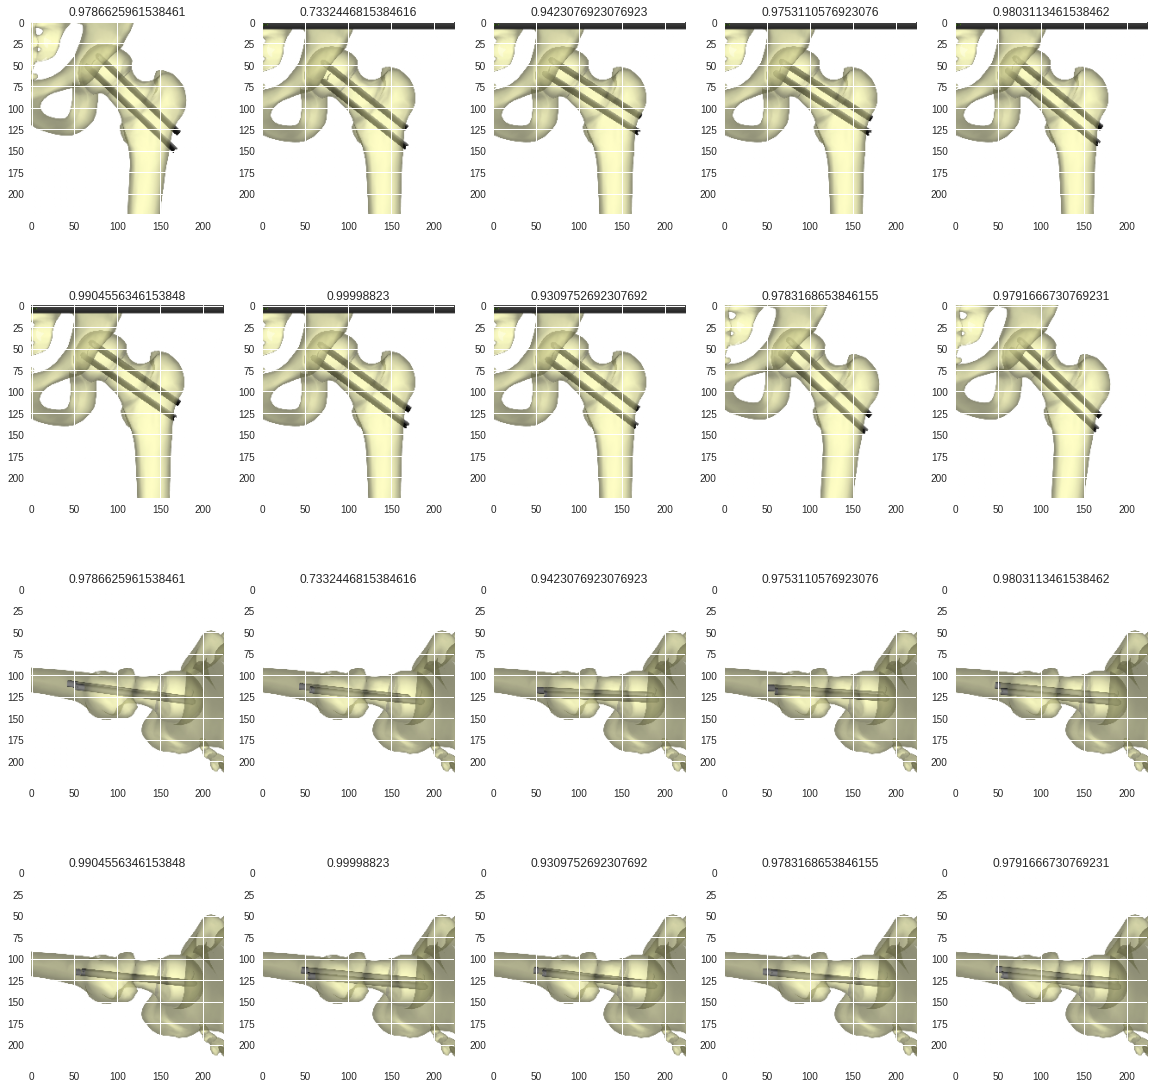

In [4]:
# show some of the first images
scaler = StandardScaler()
images, scores = next(iter(train_loader))
plt.figure(figsize=(20,20))

num_images = 20

for i in range(int(num_images/2)):
    plt.subplot(4,5,i+1)
    plt.imshow(images[i][:,0,:,:].permute(1, 2, 0), cmap = 'gray')
    plt.title(scores[i].item())#*scaler.std)+scaler.mean) # convert back from scaled values

for i in range(int(num_images/2)):
    plt.subplot(4,5,int(num_images/2) + i+1)
    plt.imshow(images[i][:,1,:,:].permute(1, 2, 0), cmap = 'gray')
    plt.title(scores[i].item())#*scaler.std)+scaler.mean) # convert back from scaled values

In [5]:
model = MVCNN()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
decayRate = 0.96
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

In [6]:
def count_parameters(model): 
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

25559081

In [7]:
# model = VGG16()
# model.to(device)
# num_epochs = 50
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
# decayRate = 0.96
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

num_epochs = 10
loss_fun = nn.MSELoss()

out_dict = train(model, optimizer, loss_fun, num_epochs = num_epochs, train_loader = train_loader, test_loader=val_loader, scheduler = scheduler)
#out_dict = train(model, optimizer, num_epochs, validation= True, scheduler=scheduler) # scheduler = scheduler)

wandb.config = {
  "learning_rate": scheduler.get_last_lr()[0],
  "epochs": num_epochs,
  "batch_size": batch_size
}

RuntimeError: mat1 and mat2 shapes cannot be multiplied (12x2000 and 2048x1)

In [ ]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")


images, labels = next(iter(test_loader))
outputs = model(images)



In [ ]:
plt.figure(figsize=(20,20))

num_images = 20

for i in range(int(num_images/2)):
    plt.subplot(4,5,i+1)
    plt.imshow(images[i].permute(1, 2, 3, 0)[0])
    plt.title(f'{(labels[i].item()*scaler.std)+scaler.mean:.3f}, {(outputs[i].item()*scaler.std)+scaler.mean:.3f}')

for i in range(int(num_images/2)):
    plt.subplot(4,5,int(num_images/2) + i+1)
    plt.imshow(images[i].permute(1, 2, 3, 0)[1])
    plt.title(f'{(labels[i].item()*scaler.std)+scaler.mean:.3f}, {(outputs[i].item()*scaler.std)+scaler.mean:.3f}')

In [ ]:
plt.figure(figsize=(20,10))

test_scores = []
for i in range(testset.__len__()):
    _, tmp = testset.__getitem__(i)
    test_scores.append((tmp*scaler.std)+scaler.mean)

plt.subplot(1,2,1)
plt.title("True distribution of test scores")
plt.hist(test_scores, bins = 40)

test_predict = []
for minibatch_no, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            #Forward pass your image through the network
            output = model(data)
            for i in range(len(output)):
                test_predict.append((output[i].item()*scaler.std)+scaler.mean)


plt.subplot(1,2,2)
plt.title("Predicted distribution of test scores")
plt.hist(test_predict, bins = 40)

plt.show()

In [ ]:
idx = 10

images, _ = testset.__getitem__(idx)
_, model_slc = saliency(images, model)

plt.figure(figsize = (10,10))
plt.subplot(2,2,1)
plt.imshow(images.permute(1, 2, 3, 0)[0])
plt.title(f'{(labels[idx].item()*scaler.std)+scaler.mean:.3f}, {(outputs[idx].item()*scaler.std)+scaler.mean:.3f}')
plt.imshow(model_slc[0], cmap = plt.cm.hot, alpha = 0.5)
plt.subplot(2,2,2)
plt.title('Saliency map frontal')
plt.imshow(model_slc[0], cmap = plt.cm.hot)
plt.subplot(2,2,3)
plt.imshow(images.permute(1, 2, 3, 0)[1])
plt.title(f'{(labels[idx].item()*scaler.std)+scaler.mean:.3f}, {(outputs[idx].item()*scaler.std)+scaler.mean:.3f}')
plt.imshow(model_slc[1], cmap = plt.cm.hot, alpha = 0.5)
plt.subplot(2,2,4)
plt.title('Saliency map lateral')
plt.imshow(model_slc[1], cmap = plt.cm.hot)

plt.show()



In [12]:
from sklearn.preprocessing import StandardScaler
import torch
import numpy as np
x = [1,2,3,4,5,6,7]
x = torch.Tensor(x)
scaler = StandardScaler()
scaler.fit(x.reshape(-1,1))

StandardScaler()

In [15]:
torch.mean(x)

tensor(4.)

In [17]:
torch.std(x)

tensor(2.1602)